# Sizing Code
By: Joseph Carruth
Goal of this is to determine the dash-1 initial sizing.

In [1]:
import math

import pandas as pd
import numpy as np


df = pd.read_csv('airfoil_data.csv')

def solverho(h):
    """
    This function is used to determine the air density (rho)
    provided the altitude in feet.
    """
    temp = 59 - 0.00356 * h
    press = 2116 * ((temp + 459.7) / 518.6) ** 5.256
    rho = press / (1718 * (temp + 459.7))

    return rho
def velocity(h, M):
    """
    This function is used to determine the speed at which plane is flying in kts given 
    altitude and mach number
    """
    R = 287.05  # Specific gas constant for air (J/kg*K)
    gamma = 1.4  # Ratio of specific heats for air
    T0 = 288.15  # Standard temperature at sea level (K)
    L = 0.0065  # Standard temperature lapse rate (K/m)

    # Convert altitude from feet to meters
    altitude_m = h * 0.3048

    # Calculate temperature at altitude
    T = T0 - L * altitude_m

    # Calculate speed of sound at altitude
    a = math.sqrt(gamma * R * T)

    # Calculate true airspeed in m/s
    tas_mps = M * a

    # Convert true airspeed from m/s to knots
    tas_knots = tas_mps * 1.94384

    return tas_knots



# This section of code determines power loading.
#Vmax = int(input("Enter desired maximum velocity in knots:"))
# Whp = 680 * Vmax ** -0.79               # Weight to HP ratio smooth, retractable, not sure if I need this yet 

# This section of code determines wing loading.
#Vstall = int(input("Enter desired stall velocity in knots:"))
Vstall = 150 #kts
h = 0                       # Represents sea level
rho = solverho(h)
qstall = 0.5 * rho * ((Vstall * 1.689) ** 2) # dynamic pressure
Clmax = 1.5                 # maximum lift coefficient will need to adjust for sweep on second pass
WS = qstall * Clmax         # Weight to Wing area ratio

# This section of code determines airplane sizing.

SwetSref = 5.25              # Business Jet

Cfe = 0.0026                 # skin friction drag coeff
Cd0 = Cfe * SwetSref
A = 7.18                      # aspect ratio gulfstream
#A = float(input("Enter Aspect Ratio:"))         # Aspect ratio
# K = 0.424 / A              # Drag due to lift factor

h = 45000 
M = .875 # mach cruise
# h = float(input("Enter cruise altitude in feet:"))
Vcruise = 520            # cruise speed in knots at altitude 45000 
#Vcruise = int(input("Enter cruise velocity (kts):"))  # desired cruise velocity
Vcr = Vcruise * 1.689       # kts to fps should be 864.2 fps

rho = solverho(h)           # air density @ 9000 ft, slugs/ft^3
qcruise = 0.5 * rho * (Vcr ** 2) # dynamic pressure

#oswald efficiency factor
sweep = 37 # in degrees
e = 4.61*(1-0.045*A**(.68))*(math.cos(math.radians(sweep)))**(0.15)-3.1

# Wing Loading at Cruise
WScr = qcruise*(math.pi * 7.7 * e * Cd0 / 3)**.5

# Wing Loading Takeoff
WSto = WScr/(.975*.985) #historical

h = 20000
# h = float(input("Enter loiter altitude in feet:"))
rho = solverho(h)
Vloiter = 200 # loiter speed in kts
Vltr = Vloiter * 1.689 #convert to fps
qloiter = 0.5 * rho * (Vltr ** 2)
WSltr = qloiter * (math.pi * A * e * Cd0 )**.5

n = 2.5 # gloading for AWACS mission
TW = qloiter * Cd0 / WSltr + WSltr * (n**2/(qloiter*math.pi*A*e))

WStrn = (TW + (TW**2 -(4*n**2*Cd0/(math.pi*A*e))))/(2*n**2)*(qloiter*math.pi*A*e)

LD = 1/ ((qcruise * Cd0 / (WS)) + ((WS)/ (qcruise*math.pi*A*e)))


c = 0.625 / 3600 # SFC lbs/hr/hp to lbs/sec/hp


 
# Range = Vcruise * 4 * 6076 # 4 hour cruise range in feet
Range = 4000 # nautical miles # should try to get this back to level I wanted, need to subtract TO, Landing, Sprint, Loiter

W1W0 = .975 # historical taxi and takeoff

W2W1 = 1.0065 - 0.0325*M # climb

W3W2 = math.exp(-Range*6076.12*c/(LD*Vcr)) # cruise

Mhigh = .95 

W4W3 = 1.0065 - .0325*Mhigh # accelerate

chigh = .65 /3600 # increase sfc to .7

W5W4 = math.exp(-300*6076*chigh/(968.5*LD)) # high speed cruise, short

W6W5 = 1 # descent 

WSltrnew = WS * (W1W0)*W2W1*W3W2*W4W3*W5W4*W6W5
Vbstltr = (2*WSltrnew/rho *(1/(Cd0*math.pi*A*e))**.5)**.5  # this comes to roughly 315 knots
q=.5*rho*Vbstltr**2
LD = 1/(q*Cd0/WSltrnew + WSltrnew/(q*math.pi*A*e))

endurance = 1.5 # in hours
W7W6 = math.exp(-endurance*.65/(LD)) #endurance and SFC are hrs / hrs 

W8W7 = .9925 #historical descent
W9W8 = .995 #historical landing and taxi

W9W0 = (W1W0)*W2W1*W3W2*W4W3*W5W4*W6W5*W7W6*W8W7*W9W8

WfW0 = 1.06*(1-W9W0)



#WfW0 = (1 - 0.975 * 2.7183 ** -((Range * c) / (550 * LD))) * 1.06

a = .32 # I may have this backwards

for W0g in range(50000, 110000):
    WeW0 = a + .927*W0g ** -0.13
    W0 = 7500 / (1 - WeW0 - WfW0)
    if W0 - W0g < 1: #convergence
        break

We = W0 * WeW0
# HP = W0 / Whp

# D3 = 1.50 * HP ** 0.25
# n = 2700 / 60
# Vtip = math.sqrt((Vcr ** 2) + (math.pi * n * D3)**2)

S = W0 / WS
b = math.sqrt(A * S)

lamda = 0.6
Croot = (2 * S) / (b * (1 + lamda))
Ctip = lamda * Croot
MAC = (2 / 3) * Croot * ((1 + lamda + lamda ** 2) / (1 + lamda))

Ccr = WS / qcruise

alpha = Ccr * (10 + 18 / A) + -4.2 #find trim angle 



print("W/S:", WS)
print("W/S Cruise:", WScr)
print("W/S TO:", WSto)
print("W/S Loiter:", WSltr)
print("W/S Turn:", WStrn)
print("Lift/Drag", LD)
print("Range:", Range)
print("Wf/W0:", WfW0)
print("WeW0:", WeW0)
print("W0:", W0)
print("We:", We)
# print("HP:", HP)
# print("Propeller Diameter:", D3)
# print("Tip Speed:", Vtip)
print("Wing Area (ft^2):", S)
print("Wing Span (ft):", b)
print("Root Chord:", Croot)
print("Tip Chord:", Ctip)
print("Mean Aerodynamic Chord:", MAC)
print("coefficient of lift (cruise):", Ccr)
print("Alpha incidence angle:", alpha)

# NASA/Langley LS(1)-0413 Airfoil co-ordinates
AFx = df['x']

AFy = df['y']

W/S: 114.4246125696952
W/S Cruise: 48.529256118063415
W/S TO: 50.53156956195592
W/S Loiter: 30.85345025402303
W/S Turn: 20.072402735053103
Lift/Drag 15.622257785107575
Range: 4000
Wf/W0: 0.4145118567232479
WeW0: 0.5249741991819648
W0: 123938.37671945845
We: 65064.45006621037
Wing Area (ft^2): 1083.1443859507804
Wing Span (ft): 88.18716851745837
Root Chord: 15.352919310142475
Tip Chord: 9.211751586085485
Mean Aerodynamic Chord: 12.538217436616351
coefficient of lift (cruise): 0.6012357225502851
Alpha incidence angle: 3.3196334101693035


In [2]:
Vbstltr

527.028707722418

In [6]:
WfW0*W0

51373.92665324808

## Sizing Code Part 2
Found online to test my code. 

In [3]:

def TGW(EmptyW_F, Fuel_F, Crew_W, Payload_W):
    return (Crew_W+Payload_W)/(1-Fuel_F-EmptyW_F)
#e.g. ASW example
Crew_Weight = 500 #lb
Payload_Weight = 7000 #lb
Fuel_Fraction = 0.415
Empty_Weight_Fraction = 0.52
print("Crew Weight %.2f lb" % (Crew_Weight))
print("Payload Weight %.2f lb" % (Payload_Weight))
print("Fuel Fraction %.4f" % (Fuel_Fraction,))
print("Empty Weight Fractiont %.4f" % (Empty_Weight_Fraction,))
TGW_tmp_1 = TGW(Empty_Weight_Fraction, Fuel_Fraction, Crew_Weight, Payload_Weight)
print("Takeoff Gross Weight W_0 %.2f lb" % (TGW_tmp_1))

Crew Weight 500.00 lb
Payload Weight 7000.00 lb
Fuel Fraction 0.4150
Empty Weight Fractiont 0.5200
Takeoff Gross Weight W_0 115384.62 lb


In [4]:
def EWF(TakeoffG_W,HS_metric,WeightS_E,VWS=False,VWS_penalty=1.04):
    if VWS:
        VWS_p_factor = VWS_penalty
    else:
        VWS_p_factor = 1
        
    return HS_metric*pow(TakeoffG_W, WeightS_E)*VWS_p_factor

bomber_HS_metric = 1.02
bomber_weight_sensitivty_e = -0.06
estimated_TGW = 115000
print(EWF(estimated_TGW,bomber_HS_metric,bomber_weight_sensitivty_e))

0.506942032045072


In [5]:
def FF(mission_ratio,RT_Allowance=1.06):
    return RT_Allowance*(1-mission_ratio)

In [6]:
def cruise_WF(Range, Specific_FC, velocity, LD_ratio):
    return math.exp((-1*Range*Specific_FC)/(velocity*LD_ratio))

high_bypass_turbofan_cruise_SFC = .6/3600

In [7]:
def accel_WF(Range, Specific_FC, M, LD_ratio):
    accelwf = 1.0065 - .0325*M
    return accelwf

high_bypass_turbofan_accel_SFC = .65/3600

In [8]:
def loiter_WF(Endurance, Specific_FC, LD_ratio):
    return math.exp((-1*Endurance*Specific_FC)/(LD_ratio))

high_bypass_turbofan_loiter_SFC = 0.0001111

In [9]:
class AircraftMission:
    variable_stan_disp = {'name':{'description':'Name:','format':'%s'},
                         'weight_fraction':{'description':'WF:','format':'%.4f'},
                         'description':{'description':'Description:','format':'%s'},
                         'segment':{'description':'Segment:','format':'%i'}}
    def __init__(self):
        self.segments=[]
    
    def append_segment(self, seg_name, seg_WF, seg_description='None Provided'):
        no_of_segments = len(self.segments)
        self.segments.append({'segment':no_of_segments+1,'name':seg_name,'weight_fraction':seg_WF,'description':seg_description})
    
    def mission_weight_ratio(self):
        no_of_segments = len(self.segments)
        if no_of_segments <= 0:
            raise ValueError('No mission segments have been added to the mission!')
        
        mwr = 1
        for a in range(0,no_of_segments):
            mwr = mwr*self.segments[a]['weight_fraction']
        return mwr
    
    def landing_weight(self, TakeoffG_W):
        return TakeoffG_W * self.mission_weight_ratio()
    
    def display_mission(self,itp=['segment','name','weight_fraction','description'],p_dict=variable_stan_disp):
        no_of_segments = len(self.segments)
        if no_of_segments <= 0:
            raise ValueError('No mission segments have been added to the mission!')
        
        for a in range(0,no_of_segments):
            disp_list = [p_dict[item_a]['description']+p_dict[item_a]['format']+' ' for item_a in itp]
            variable_list = [self.segments[a][item_b] for item_b in itp]
            disp_string = ''.join(disp_list) % tuple(variable_list)
            print(disp_string)
            
        
        
    
    
    
ASW_LD_max = 16
cruise_LD_ratio = ASW_LD_max * 0.866
loiter_LD_ratio = ASW_LD_max
cruise_velocity = 864 # ft/s
cruise_SFC = high_bypass_turbofan_cruise_SFC
loiter_SFC = high_bypass_turbofan_loiter_SFC
accel_SFC = high_bypass_turbofan_accel_SFC
mission_loiter = 1.5*3600 # 3h in s
landing_loiter = 1200 # 20 min in s
cruise_range = 4750*6076 # 1500nm in ft
accel_range = 300*6076 # 300 nm in ft
M = .95

ASW_Mission = AircraftMission()
ASW_Mission.append_segment('Warmup and Takeoff',0.97)
ASW_Mission.append_segment('Climb',0.985)
ASW_Mission.append_segment('Cruise',cruise_WF(cruise_range,cruise_SFC,cruise_velocity,cruise_LD_ratio),seg_description='4000 nm range')
ASW_Mission.append_segment('Accelerate',accel_WF(accel_range,accel_SFC,M,cruise_LD_ratio),seg_description='300 nm sprint to Mach .95') 
ASW_Mission.append_segment('Loiter',loiter_WF(mission_loiter,loiter_SFC,loiter_LD_ratio),seg_description='1.5 hr Loiter') 
ASW_Mission.append_segment('Land',0.995)
ASW_Mission.display_mission()

MWR_tmp = ASW_Mission.mission_weight_ratio()
print("Misson Weight Ratio %.4f" % (MWR_tmp,))
FF_tmp = FF(MWR_tmp)
print("Fuel Fraction %.4f" % (FF_tmp,))
TakeoffG_W_estimate = 115000
EWF_tmp = EWF(TakeoffG_W_estimate,1.02,-0.06)
print("Empty Weight Fraction %.5f based on TGW W_0 estimate %.3f lb" % (EWF_tmp,TakeoffG_W_estimate))
TGW_tmp = TGW(EWF_tmp , FF_tmp, Crew_Weight, Payload_Weight)
print("Takeoff Gross Weight W_0 %.3f lb"  % (TGW_tmp))
LGW_tmp = ASW_Mission.landing_weight(TGW_tmp)
print("Landing Gross Weight W_x %.3f lb"  % (LGW_tmp))
fuel_burn = TGW_tmp-LGW_tmp
print("Fuel Burned %.3f lb"  % (fuel_burn))


    
def calc_WG0(WGV,Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS=False,VWS_penalty=1.04):
    EWF_calc = EWF(WGV,HS_metric,WeightS_E,VWS=False,VWS_penalty=1)
    return TGW(EWF_calc, Fuel_F, Crew_W, Payload_W)

def diff_calc_WG0(WGV,Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS=False,VWS_penalty=1):
    tmp_wgv = calc_WG0(WGV,Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS,VWS_penalty)
    result = WGV - tmp_wgv
    if result < 0:
        mag_result = result * -1
    else:
        mag_result=result
    return mag_result
    

def calc_WG0_array(WGV_list,Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS=False,VWS_penalty=1.04):
    WG0_array=[]
    EWF_array=[]
    diff_array=[]
    for a in range(0,len(WGV_list)):
        WG0_array.append(calc_WG0(WGV_list[a],Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS,VWS_penalty))
        EWF_array.append(EWF(WGV_list[a],HS_metric,WeightS_E,VWS=False,VWS_penalty=1))
        diff_array.append(diff_calc_WG0(WGV_list[a],Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS,VWS_penalty))
    return WG0_array, EWF_array, diff_array

Segment:1 Name:Warmup and Takeoff WF:0.9700 Description:None Provided 
Segment:2 Name:Climb WF:0.9850 Description:None Provided 
Segment:3 Name:Cruise WF:0.6691 Description:4000 nm range 
Segment:4 Name:Accelerate WF:0.9756 Description:300 nm sprint to Mach .95 
Segment:5 Name:Loiter WF:0.9632 Description:1.5 hr Loiter 
Segment:6 Name:Land WF:0.9950 Description:None Provided 
Misson Weight Ratio 0.5978
Fuel Fraction 0.4264
Empty Weight Fraction 0.50694 based on TGW W_0 estimate 115000.000 lb
Takeoff Gross Weight W_0 112462.257 lb
Landing Gross Weight W_x 67226.019 lb
Fuel Burned 45236.237 lb


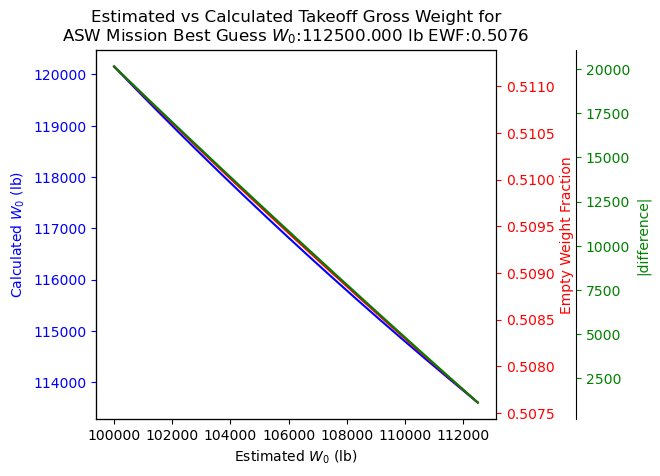

In [10]:
import numpy as np
import matplotlib.pyplot as plt
WGV_array = [100000]
for a in range(0,250):
    WGV_array.append(WGV_array[a]+50)
    
calc_WG0_tmp, calc_EWF_tmp, diff_array = calc_WG0_array(WGV_array,FF_tmp,Crew_Weight, Payload_Weight, bomber_HS_metric,bomber_weight_sensitivty_e)
best_guess_index = np.argmin(diff_array)
fig, ax = plt.subplots()
axes = [ax, ax.twinx(), ax.twinx()]
fig.subplots_adjust(right=0.75)
axes[-1].spines['right'].set_position(('axes', 1.2))
axes[0].plot(WGV_array,calc_WG0_tmp,c='b')
axes[0].set_title('Estimated vs Calculated Takeoff Gross Weight for\nASW Mission Best Guess $W_0$:%.3f lb EWF:%.4f' % (WGV_array[best_guess_index],calc_EWF_tmp[best_guess_index]))
axes[0].set_ylabel('Calculated $W_0$ (lb)',color='b')
axes[0].set_xlabel('Estimated $W_0$ (lb)')
axes[0].tick_params('y', colors='b')
axes[1].plot(WGV_array,calc_EWF_tmp,c='r')
axes[1].set_ylabel('Empty Weight Fraction',color='r')
axes[1].tick_params('y', colors='r')
axes[2].plot(WGV_array,diff_array,c='g')
axes[2].set_ylabel('|difference|',color='g')
axes[2].tick_params('y', colors='g')
plt.show()


In [11]:
import scipy.optimize as optimize
minimum_W_0 = optimize.minimize(diff_calc_WG0,100000, args = (FF_tmp,Crew_Weight, Payload_Weight, bomber_HS_metric,bomber_weight_sensitivty_e))
min_EWF = EWF(minimum_W_0.x,1.02,-0.06)
print("Optimised Takeoff Gross Weight W_0 found %.3f lb with EWF %.4f" % (minimum_W_0.x,min_EWF))

Optimised Takeoff Gross Weight W_0 found 113253.231 lb with EWF 0.5074


/var/folders/2m/j1mxfjpd7pl5zmd8sqqqcn_m0000gn/T/ipykernel_17802/3392062589.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Optimised Takeoff Gross Weight W_0 found %.3f lb with EWF %.4f" % (minimum_W_0.x,min_EWF))
